In [2]:
import pickle

# Load the pickle files
print("Loading data...")
with open("mon_standard.pkl", 'rb') as fi:  # Monitored 데이터 로드
    mon_data = pickle.load(fi)

with open("unmon_standard10_3000.pkl", 'rb') as fi:  # Unmonitored 데이터 로드
    unmon_data = pickle.load(fi)


Loading data...


In [22]:
import pickle
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 데이터 로드
print("Loading data...")
with open("mon_standard.pkl", 'rb') as fi:
    mon_data = pickle.load(fi)

with open("unmon_standard10_3000.pkl", 'rb') as fi:
    unmon_data = pickle.load(fi)

def process_data_multi_class(data, label_value=None, is_monitored=True, max_monitored_labels=94):
    """
    다중 클래스 데이터 전처리 함수
    :param data: dict 또는 list 형태의 데이터
    :param label_value: 라벨 값 (monitored 웹사이트 번호 또는 -1)
    :param is_monitored: Monitored 데이터 여부 (True/False)
    :param max_monitored_labels: Monitored 데이터의 최대 라벨 수
    :return: 전처리된 데이터 (X1, X2, y)
    """
    X1, X2, y = [], [], []

    if is_monitored:  # Monitored 데이터
        for site_id, samples in enumerate(data.values()):
            if site_id >= max_monitored_labels:
                break  # 라벨 범위를 제한
            for sample in samples:
                X1.append([abs(c) for c in sample])
                X2.append([(1 if c > 0 else -1) * 512 for c in sample])
                y.append(site_id)  # {0, 1, 2, ..., max_monitored_labels - 1}로 라벨 할당
    else:  # Unmonitored 데이터
        for sample in data:
            if isinstance(sample, list):
                X1.append([abs(c) for c in sample])
                X2.append([(1 if c > 0 else -1) * 512 for c in sample])
                y.append(-1)  # Unmonitored 데이터는 항상 -1 라벨

    return X1, X2, y

# Monitored 데이터 처리
X1_mon, X2_mon, y_mon = process_data_multi_class(
    mon_data, label_value=None, is_monitored=True, max_monitored_labels=95
)

# Unmonitored 데이터 처리
X1_unmon, X2_unmon, y_unmon = process_data_multi_class(
    unmon_data, label_value=-1, is_monitored=False
)

# 데이터 결합
X1 = X1_mon + X1_unmon
X2 = X2_mon + X2_unmon
y = y_mon + y_unmon


# 피처 생성 함수 정의
def create_features(X1, X2):
    X = []
    for i in range(len(X1)):
        packet_size_direction = sum(X2[i])
        cumulative_packet_size = np.sum([abs(c) for c in X2[i]])
        burst_lengths = len([c for c in X2[i] if c != 0])

        num_incoming_packets = len([c for c in X2[i] if c > 0])
        ratio_incoming_packets = num_incoming_packets / len(X2[i]) if len(X2[i]) > 0 else 0
        num_outgoing_packets = len([c for c in X2[i] if c < 0])
        total_packet_count = len(X2[i])

        feature_vector = [
            packet_size_direction,
            np.mean(X1[i]) if X1[i] else 0,
            cumulative_packet_size,
            burst_lengths,
            num_incoming_packets,
            ratio_incoming_packets,
            num_outgoing_packets,
            total_packet_count
        ]
        X.append(feature_vector)
    return np.array(X)

# 피처 생성
X = create_features(X1, X2)
y = np.array(y)  # 레이블을 numpy array로 변환

# 데이터프레임 생성
data = pd.DataFrame({
    'features': list(X),
    'label': y
})

# Monitored와 Unmonitored 데이터 분리
data_monitored = data[data['label'] != -1]
data_unmonitored = data[data['label'] == -1]

# Monitored 데이터 다운샘플링
data_monitored_downsampled = resample(
    data_monitored,
    replace=True,
    n_samples=len(data_unmonitored),
    random_state=42
)

# 데이터 결합 및 분리
balanced_data = pd.concat([data_monitored, data_unmonitored_downsampled])
X_balanced = np.array(balanced_data['features'].tolist())
y_balanced = balanced_data['label'].values

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

# 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Random Forest 모델 학습
rf_model = RandomForestClassifier(
    n_estimators=300, max_depth=30, random_state=42, n_jobs=-1
)
rf_model.fit(X_train, y_train)

# 예측 및 평가
y_pred = rf_model.predict(X_test)

# 평가 지표 출력
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Loading data...
Accuracy: 0.7105263157894737
Confusion Matrix:
 [[345   0   0 ...   1   0   1]
 [  2   2   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  3   0   0 ...   1   0   0]
 [  1   0   0 ...   0   2   0]
 [  2   0   0 ...   0   1   0]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.80      0.91      0.85       380
           0       0.67      0.50      0.57         4
           1       1.00      1.00      1.00         4
           2       0.67      0.50      0.57         4
           3       1.00      0.50      0.67         4
           4       0.25      0.25      0.25         4
           5       1.00      0.75      0.86         4
           6       1.00      0.75      0.86         4
           7       0.50      0.75      0.60         4
           8       0.75      0.75      0.75         4
           9       1.00      0.50      0.67         4
          10       0.00      0.00      0.00         4
          11     

/Users/sojeonglee/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sojeonglee/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sojeonglee/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

라벨링 검증

In [12]:
# Unmonitored 데이터 라벨 확인
print(f"Unmonitored 데이터 라벨: {set(y)}")


Unmonitored 데이터 라벨: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, -1}


In [13]:
# 결과 평가
print("데이터 라벨 분포 확인:")
print(pd.Series(y).value_counts())  # 라벨 분포 확인

데이터 라벨 분포 확인:
-1     3000
 1       20
 70      20
 69      20
 68      20
       ... 
 29      20
 28      20
 27      20
 26      20
 48      20
Name: count, Length: 96, dtype: int64


In [15]:
# Monitored와 Unmonitored 데이터의 라벨 분포 확인
def validate_labels(y_mon, y_unmon):
    """
    Monitored와 Unmonitored 데이터의 라벨 분포 검증
    :param y_mon: Monitored 데이터 라벨 리스트
    :param y_unmon: Unmonitored 데이터 라벨 리스트
    :return: 검증 결과 출력
    """
    print("\n--- 검증 시작 ---")
    
    # Monitored 라벨 검증
    mon_unique_labels = set(y_mon)
    if mon_unique_labels == set(range(95)):  # 0 ~ 94
        print("Monitored 데이터 라벨링: 정상 (0 ~ 94)")
    else:
        print(f"Monitored 데이터 라벨링 오류: {mon_unique_labels}")
    
    # Unmonitored 라벨 검증
    unmon_unique_labels = set(y_unmon)
    if unmon_unique_labels == {-1}:  # Only -1
        print("Unmonitored 데이터 라벨링: 정상 (-1)")
    else:
        print(f"Unmonitored 데이터 라벨링 오류: {unmon_unique_labels}")
    
    print("--- 검증 완료 ---\n")

# Monitored와 Unmonitored 데이터 각각 분리
monitored_labels = y_mon  # Monitored 라벨 리스트
unmonitored_labels = y_unmon  # Unmonitored 라벨 리스트

# 검증 함수 실행
validate_labels(monitored_labels, unmonitored_labels)



--- 검증 시작 ---
Monitored 데이터 라벨링: 정상 (0 ~ 94)
Unmonitored 데이터 라벨링: 정상 (-1)
--- 검증 완료 ---



In [16]:
print(y_unmon)

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

In [17]:
print(y_mon)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,

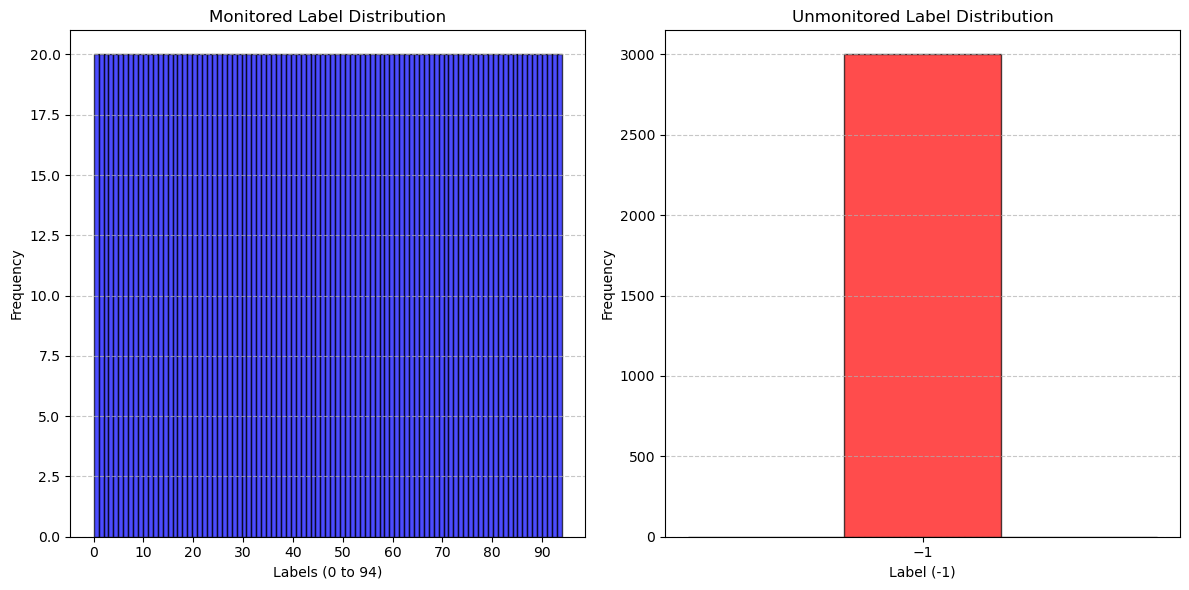

In [18]:
import matplotlib.pyplot as plt

# 라벨 분포 시각화 함수
def plot_label_distribution(y_mon, y_unmon):
    """
    Monitored와 Unmonitored 데이터의 라벨 분포 시각화
    :param y_mon: Monitored 데이터 라벨 리스트
    :param y_unmon: Unmonitored 데이터 라벨 리스트
    """
    # Monitored 데이터 라벨 분포
    plt.figure(figsize=(12, 6))
    
    # Monitored 라벨 분포 히스토그램
    plt.subplot(1, 2, 1)
    plt.hist(y_mon, bins=len(set(y_mon)), color='blue', alpha=0.7, edgecolor='black')
    plt.title("Monitored Label Distribution")
    plt.xlabel("Labels (0 to 94)")
    plt.ylabel("Frequency")
    plt.xticks(range(0, 95, 10))  # x축 간격 설정
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Unmonitored 데이터 라벨 분포
    plt.subplot(1, 2, 2)
    plt.hist(y_unmon, bins=3, color='red', alpha=0.7, edgecolor='black')  # -1 하나만 있어야 함
    plt.title("Unmonitored Label Distribution")
    plt.xlabel("Label (-1)")
    plt.ylabel("Frequency")
    plt.xticks([-1])  # -1 라벨만 표시
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 그래프 표시
    plt.tight_layout()
    plt.show()

# 시각화 함수 실행
plot_label_distribution(monitored_labels, unmonitored_labels)


In [19]:
# Monitored 데이터 샘플 수 확인
num_monitored_samples = len(data_monitored)
print(f"Monitored 데이터 샘플 수: {num_monitored_samples}")


Monitored 데이터 샘플 수: 1900
